# Attribution Modelling 

<h3> Dataset Description </h3>

This dataset represents a sample of 30 days of Criteo live traffic data. Each line corresponds to one impression (a banner) that was displayed to a user. For each banner we have detailed information about the context, if it was clicked, if it led to a conversion and if it led to a conversion that was attributed to Criteo or not. Data has been sub-sampled and anonymized so as not to disclose proprietary elements.

Here is a detailed description of the fields (they are tab-separated in the file):

timestamp: timestamp of the impression (starting from 0 for the first impression). The dataset is sorted according to timestamp.

uid: a unique user identifier

campaign: a unique identifier for the campaign

conversion: 1 if there was a conversion in the 30 days after the impression (independently of whether this impression was last click or not)

conversion_timestamp: the timestamp of the conversion or -1 if no conversion was observed

conversion_id: a unique identifier for each conversion (so that timelines can be reconstructed if needed). -1 if there was no conversion

attribution: 1 if the conversion was attributed to Criteo, 0 otherwise

click: 1 if the impression was clicked, 0 otherwise

click_pos: the position of the click before a conversion (0 for first-click)

click_nb: number of clicks. More than 1 if there was several clicks before a conversion

cost: the price paid by Criteo for this display (disclaimer: not the real price, only a transformed version of it)

cpo: the cost-per-order in case of attributed conversion (disclaimer: not the real price, only a transformed version of it)

time_since_last_click: the time since the last click (in s) for the given impression

cat(1-9): contextual features associated to the display. Can be used to learn the click/conversion models. We do not disclose the meaning of these features but it is not relevant for this study. Each column is a categorical variable. In the experiments, they are mapped to a fixed dimensionality space using the Hashing Trick (see paper for reference).

<h3> Importing dependencies </h3>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


plt.style.use('ggplot')

<h3> Data pre-processing and preparation </h3>

In [2]:
# Initial data preparation

def add_derived_columns(df):
    df_ext = df.copy()
    df_ext['jid'] = df_ext['uid'].map(str) + '_' + df_ext['conversion_id'].map(str)
    
    min_max_scaler = MinMaxScaler()
    for cname in ('timestamp', 'time_since_last_click'):
        x = df_ext[cname].values.reshape(-1, 1) 
        df_ext[cname + '_norm'] = min_max_scaler.fit_transform(x)
    
    return df_ext

def filter_journeys_by_length(df, min_touchpoints):
    if min_touchpoints <= 1:
        return df
    else:
        grouped = df.groupby(['jid'])['uid'].count().reset_index(name="count")
        return df[df['jid'].isin( grouped[grouped['count'] >= min_touchpoints]['jid'].values )]

def sample_campaigns(df, n_campaigns):    
    campaigns = np.random.choice( df['campaign'].unique(), n_campaigns, replace = False )
    return df[ df['campaign'].isin(campaigns) ]

def balance_conversions(df):
    df_minority = df[df.conversion == 1]
    df_majority = df[df.conversion == 0]
    
    df_majority_jids = np.array_split(df_majority['jid'].unique(), 100 * df_majority.shape[0]/df_minority.shape[0] )
    
    df_majority_sampled = pd.DataFrame(data=None, columns=df.columns)
    for jid_chunk in df_majority_jids:
        df_majority_sampled = pd.concat([df_majority_sampled, df_majority[df_majority.jid.isin(jid_chunk)]])
        if df_majority_sampled.shape[0] > df_minority.shape[0]:
            break
    
    return pd.concat([df_majority_sampled, df_minority]).sample(frac=1).reset_index(drop=True)

def map_one_hot(df, column_names, result_column_name):
    mapper = {} 
    for i, col_name in enumerate(column_names):
        for val in df[col_name].unique():
            mapper[str(val) + str(i)] = len(mapper)
         
    df_ext = df.copy()
    
    def one_hot(values):
        v = np.zeros( len(mapper) )
        for i, val in enumerate(values): 
            v[ mapper[str(val) + str(i)] ] = 1
        return v    
    
    df_ext[result_column_name] = df_ext[column_names].values.tolist()
    df_ext[result_column_name] = df_ext[result_column_name].map(one_hot)
    
    return df_ext
    
data_file = 'criteo_attribution_dataset.tsv.gz'
df0 = pd.read_csv(data_file, sep='\t', compression='gzip')

n_campaigns = 400

df1 = add_derived_columns(df0)
df2 = sample_campaigns(df1, n_campaigns)
df3 = filter_journeys_by_length(df2, 2)
df4 = balance_conversions(df3)
df5 = map_one_hot(df4, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8'], 'cats')
df6 = map_one_hot(df5, ['campaign'], 'campaigns').sort_values(by=['timestamp_norm'])

print(df6.shape[0])
print([df6[df6.conversion == 0].shape[0], df6[df6.conversion == 1].shape[0]])

643712
[324339, 319373]


<h3> Last Touch Atrribution </h3>

In [3]:
def last_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
        
    return campaign_conversions / campaign_impressions
    
lta = last_touch_attribution(df6)
print(lta)

[0.09875609 0.15702341 0.1733945  0.03495261 0.10203651 0.07416709
 0.19849179 0.05288754 0.02855443 0.13968579 0.07606347 0.13669881
 0.25284683 0.09560724 0.23159278 0.05702648 0.17608837 0.05748007
 0.10356286 0.17735226 0.10948905 0.16745773 0.16097279 0.30580357
 0.00996933 0.25064599 0.25384615 0.13956848 0.20971914 0.19779438
 0.13549832 0.08247191 0.13842924 0.14575375 0.05531295 0.08436725
 0.07823961 0.09787234 0.09424965 0.1445702  0.12901786 0.14037985
 0.09183673 0.16977174 0.11585682 0.06127389 0.16903313 0.20991254
 0.17272727 0.09869119 0.17893871 0.07539683 0.08888181 0.11413748
 0.20069204 0.09611452 0.04633205 0.08888889 0.17355591 0.11521548
 0.09054086 0.05593923 0.15128826 0.23463687 0.09942775 0.05762082
 0.01680672 0.07860262 0.05718824 0.11661862 0.13892365 0.1289161
 0.342723   0.11661808 0.07936508 0.13780025 0.15570809 0.28571429
 0.09662577 0.12815534 0.27553617 0.09650181 0.2115869  0.07917597
 0.07037037 0.20408163 0.34731935 0.06036942 0.10357918 0.17798

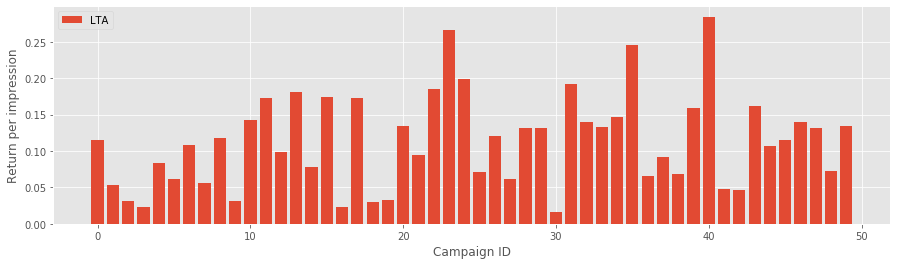

In [4]:
# Visualization of the attribution scores

campaign_idx = range(150, 200)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(lta[campaign_idx])), lta[campaign_idx], label='LTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

<h3> First Touch Attribution </h3>

In [24]:
def first_touch_attribution(df):
    campaign_count = len(df['campaign'].unique())
    print(campaign_count)
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
        
    return campaign_conversions / campaign_impressions
    
fta = first_touch_attribution(df6)


400


<h3> Visualisation of both LTA and FTA attribution scores </h3>

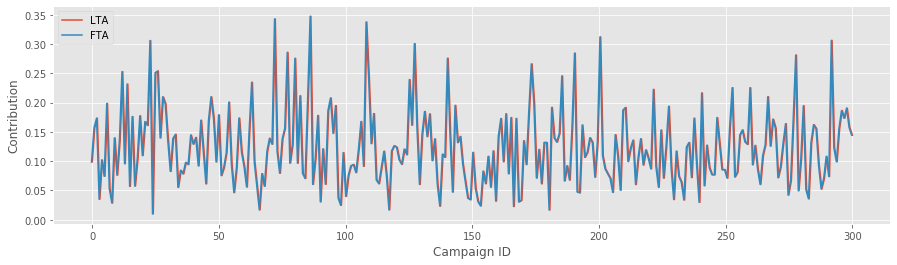

In [7]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
campaign_idx = range(0, 300)
#ratio = max(lta[idx]) / max(fta[idx])
plt.plot(np.linspace(0, len(campaign_idx), len(campaign_idx)), lta[campaign_idx], label='LTA' )
plt.plot(np.linspace(0, len(campaign_idx), len(campaign_idx)) - 0.3, fta[campaign_idx], label='FTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

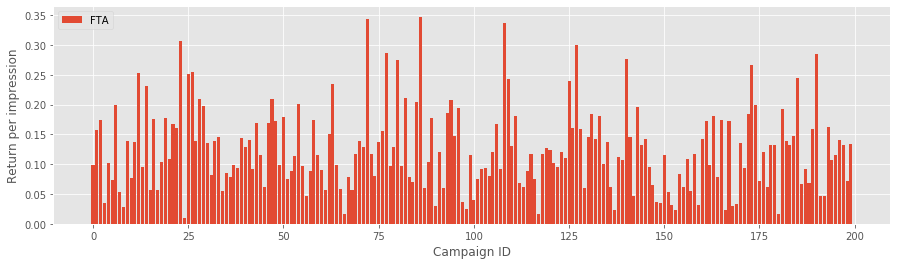

In [8]:
# Visualization of the attribution scores

campaign_idx = range(0, 200)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(fta[campaign_idx])), fta[campaign_idx], label='FTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [9]:
fta

array([0.09875609, 0.15702341, 0.1733945 , 0.03495261, 0.10203651,
       0.07416709, 0.19849179, 0.05288754, 0.02855443, 0.13968579,
       0.07606347, 0.13669881, 0.25284683, 0.09560724, 0.23159278,
       0.05702648, 0.17608837, 0.05748007, 0.10356286, 0.17735226,
       0.10948905, 0.16745773, 0.16097279, 0.30580357, 0.00996933,
       0.25064599, 0.25384615, 0.13956848, 0.20971914, 0.19779438,
       0.13549832, 0.08247191, 0.13842924, 0.14575375, 0.05531295,
       0.08436725, 0.07823961, 0.09787234, 0.09424965, 0.1445702 ,
       0.12901786, 0.14037985, 0.09183673, 0.16977174, 0.11585682,
       0.06127389, 0.16903313, 0.20991254, 0.17272727, 0.09869119,
       0.17893871, 0.07539683, 0.08888181, 0.11413748, 0.20069204,
       0.09611452, 0.04633205, 0.08888889, 0.17355591, 0.11521548,
       0.09054086, 0.05593923, 0.15128826, 0.23463687, 0.09942775,
       0.05762082, 0.01680672, 0.07860262, 0.05718824, 0.11661862,
       0.13892365, 0.1289161 , 0.342723  , 0.11661808, 0.07936

<b> Testing whether LTA and FTA are same </b>

In [25]:
np.array_equal(fta,lta)

True

<h3> Linear Attribution </h3>

In [10]:
def linear_attribution(df):
    campaign_count = len(df['campaign'].unique())
    print(campaign_count)
    
    def count_by_campaign(df):
        counters = np.zeros(campaign_count)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id]  = counters[campaign_id] + campaign_one_hot[campaign_id]
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    df_converted['count'] = df_converted.groupby(['jid']).transform('count')['timestamp']
    df_converted['linear'] = df_converted['count'].transform(lambda x: 1/x)
    df_converted['campaigns'] = df_converted['campaigns'] * df_converted['linear']
    campaign_conversions = count_by_campaign(df_converted)
        
    return campaign_conversions / campaign_impressions
    
la = linear_attribution(df6)

400


C:\Users\nancy\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\nancy\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\nancy\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

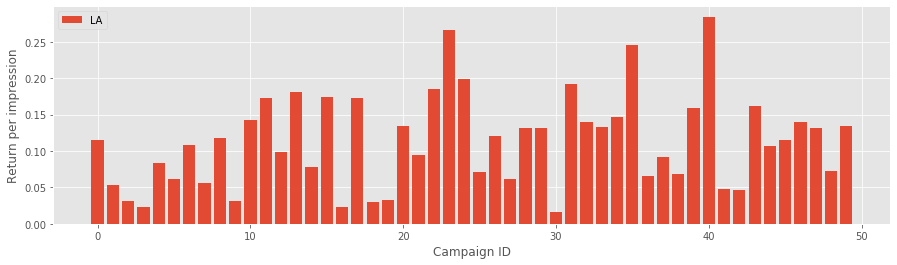

In [12]:
# Visualization of the attribution scores

campaign_idx = range(150, 200)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(la[campaign_idx])), la[campaign_idx], label='LA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [13]:
la

array([0.09875609, 0.15702341, 0.1733945 , 0.03495261, 0.10203651,
       0.07416709, 0.19849179, 0.05288754, 0.02855443, 0.13968579,
       0.07606347, 0.13669881, 0.25284683, 0.09560724, 0.23159278,
       0.05702648, 0.17608837, 0.05748007, 0.10356286, 0.17735226,
       0.10948905, 0.16745773, 0.16097279, 0.30580357, 0.00996933,
       0.25064599, 0.25384615, 0.13956848, 0.20971914, 0.19779438,
       0.13549832, 0.08247191, 0.13842924, 0.14575375, 0.05531295,
       0.08436725, 0.07823961, 0.09787234, 0.09424965, 0.1445702 ,
       0.12901786, 0.14037985, 0.09183673, 0.16977174, 0.11585682,
       0.06127389, 0.16903313, 0.20991254, 0.17272727, 0.09869119,
       0.17893871, 0.07539683, 0.08888181, 0.11413748, 0.20069204,
       0.09611452, 0.04633205, 0.08888889, 0.17355591, 0.11521548,
       0.09054086, 0.05593923, 0.15128826, 0.23463687, 0.09942775,
       0.05762082, 0.01680672, 0.07860262, 0.05718824, 0.11661862,
       0.13892365, 0.1289161 , 0.342723  , 0.11661808, 0.07936

<b> Testing whether LA and LTA are same </b>

In [28]:
np.array_equal(la,lta)

False

<h3> U Shaped Attribution </h3>

In [29]:
def U_touch_attribution(df):
    campaign_count = len(df['campaign'].unique())
    
    def count_by_campaign(df):
        counters = np.zeros(campaign_count)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id]  = counters[campaign_id] + campaign_one_hot[campaign_id]
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    df_converted['count'] = df_converted.groupby(['jid']).transform('count')['timestamp']
    #print(df_converted['count'])
    df_converted.loc[df_converted['count']>2,'U_attribution'] = (0.2/(df_converted['count']-2))
    idx_min = df_converted.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
    idx_max = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']
    idx_min = idx_min.reset_index()
    idx_max = idx_max.reset_index()
    df_converted.loc[idx_min[idx_min['timestamp_norm'] == True]['index'].values,'U_attribution'] = 0.4
    df_converted.loc[idx_max[idx_max['timestamp_norm'] == True]['index'].values,'U_attribution'] = 0.4
    df_converted.loc[df_converted['count']<3,'U_attribution'] = 1/df_converted['count']
    df_converted['campaigns'] = df_converted['campaigns'] * df_converted['U_attribution']
        
    campaign_conversions = count_by_campaign(df_converted)
        
    return campaign_conversions / campaign_impressions
    
uta = U_touch_attribution(df6)

C:\Users\nancy\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\nancy\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


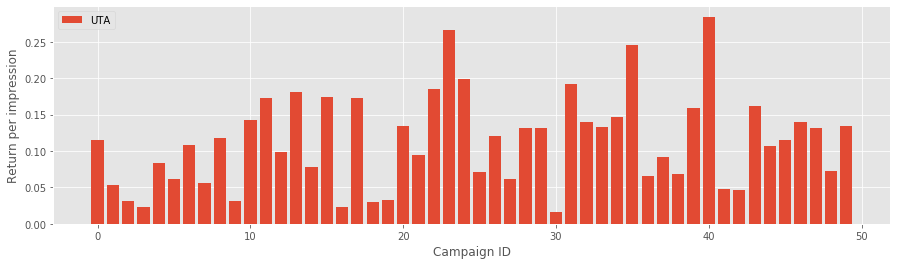

In [32]:
# Visualization of the attribution scores

campaign_idx = range(150, 200)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(uta[campaign_idx])), uta[campaign_idx], label='UTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [16]:
uta

array([0.09875609, 0.15702341, 0.1733945 , 0.03495261, 0.10203651,
       0.07416709, 0.19849179, 0.05288754, 0.02855443, 0.13968579,
       0.07606347, 0.13669881, 0.25284683, 0.09560724, 0.23159278,
       0.05702648, 0.17608837, 0.05748007, 0.10356286, 0.17735226,
       0.10948905, 0.16745773, 0.16097279, 0.30580357, 0.00996933,
       0.25064599, 0.25384615, 0.13956848, 0.20971914, 0.19779438,
       0.13549832, 0.08247191, 0.13842924, 0.14575375, 0.05531295,
       0.08436725, 0.07823961, 0.09787234, 0.09424965, 0.1445702 ,
       0.12901786, 0.14037985, 0.09183673, 0.16977174, 0.11585682,
       0.06127389, 0.16903313, 0.20991254, 0.17272727, 0.09869119,
       0.17893871, 0.07539683, 0.08888181, 0.11413748, 0.20069204,
       0.09611452, 0.04633205, 0.08888889, 0.17355591, 0.11521548,
       0.09054086, 0.05593923, 0.15128826, 0.23463687, 0.09942775,
       0.05762082, 0.01680672, 0.07860262, 0.05718824, 0.11661862,
       0.13892365, 0.1289161 , 0.342723  , 0.11661808, 0.07936

<h3> Time decay Attribution </h3>

The days are calculated by taking the difference between conversion timestamp and the timestamp event

In [17]:
df6['days_time'] = df6['conversion_timestamp'] - df6['timestamp']
df6['day'] = np.floor(df6.days_time / 86400.).astype(int)

In [18]:
def time_decay(df):
    campaign_count = len(df['campaign'].unique())
    
    def count_by_campaign(df):
        counters = np.zeros(campaign_count)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id]  = counters[campaign_id] + campaign_one_hot[campaign_id]
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    #df_converted['timestamp_max'] = df_converted.groupby(['jid'])['timestamp'].transform(max)    
    df_converted['time_decay'] = df_converted['day'].transform(lambda x: 2**(-x/7))
    df_converted['campaigns'] = df_converted['campaigns'] * df_converted['time_decay']

    campaign_conversions = count_by_campaign(df_converted)
        
    return campaign_conversions / campaign_impressions
    
tda = time_decay(df6)

C:\Users\nancy\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\nancy\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


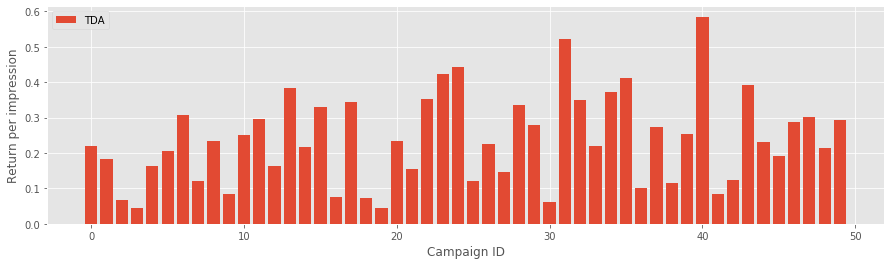

In [33]:
# Visualization of the attribution scores

campaign_idx = range(150, 200)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(tda[campaign_idx])), tda[campaign_idx], label='TDA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [19]:
tda

array([0.21235638, 0.35244658, 0.31253201, 0.06282898, 0.18361357,
       0.17961274, 0.32375318, 0.15253402, 0.0596144 , 0.29739702,
       0.13976932, 0.27365727, 0.62668171, 0.16226265, 0.49763356,
       0.09491459, 0.37390993, 0.28235061, 0.2270074 , 0.34012717,
       0.22950006, 0.35756483, 0.25992922, 0.50412216, 0.02029906,
       0.45541996, 0.52572546, 0.28946634, 0.38307282, 0.35855023,
       0.20239887, 0.25512191, 0.27198765, 0.28870455, 0.11054288,
       0.15804328, 0.13928209, 0.17597008, 0.1777461 , 0.33098942,
       0.27342706, 0.2784792 , 0.15191505, 0.32023552, 0.27727662,
       0.14894631, 0.41691371, 0.37445687, 0.31140084, 0.22529898,
       0.47697399, 0.17063603, 0.2963737 , 0.21806392, 0.40788136,
       0.26698325, 0.13992579, 0.16621858, 0.56438607, 0.18151373,
       0.16766734, 0.09701398, 0.32360854, 0.43268726, 0.32113038,
       0.11626917, 0.05060804, 0.17108742, 0.10570987, 0.26896536,
       0.25659563, 0.2586325 , 0.58941106, 0.25914315, 0.08865

<b> Testing all models attribution weights </b>

In [31]:
np.array_equal(lta,fta)
np.array_equal(la,uta)
np.array_equal(uta,tda)

False

<h3> Logistic Regression </h3>

In [73]:
def features_for_logistic_regression(df):

    def pairwise_max(series):
        return np.max(series.tolist(), axis = 0).tolist()
    
    aggregation = {
        'campaigns': pairwise_max,
        'cats': pairwise_max,
        'click': 'sum',
        'cost': 'sum',
        'conversion': 'max'
    }
    
    df_agg = df.groupby(['jid']).agg(aggregation)
    
    df_agg['features'] = df_agg[['campaigns', 'cats', 'click', 'cost']].values.tolist()
    
    return (
        np.stack(df_agg['features'].map(lambda x: np.hstack(x)).values),
        df_agg['conversion'].values
    )

<h3> Budget Optimization </h3>

In [20]:
def get_campaign_id(x_journey_step):
    return np.argmax(x_journey_step[0:n_campaigns])

def simulate_budget_roi(df, budget_total, attribution, verbose=False):
    budgets = np.ceil(attribution * (budget_total / np.sum(attribution)))
    
    if(verbose):
        print(budgets)
    
    blacklist = set()
    conversions = set()
    for i in range(df.shape[0]):
        campaign_id = get_campaign_id(df.loc[i]['campaigns']) 
        jid = df.loc[i]['jid']
        if jid not in blacklist:
            if budgets[campaign_id] >= 1:
                budgets[campaign_id] = budgets[campaign_id] - 1
                if(df.loc[i]['conversion'] == 1):
                    conversions.add(jid)
            else:
                blacklist.add(jid)
        
        if(verbose):
            if(i % 10000 == 0):
                print('{:.2%} : {:.2%} budget spent'.format(i/df.shape[0], 1.0 - np.sum(budgets)/budget_total ))
        
        if(np.sum(budgets) < budget_total * 0.02):
            break
            
    return len(conversions.difference(blacklist))

In [22]:
pitches = [1.0, 2.0,3.0]
attributions = [lta, fta, la, uta]

for i, pitch in enumerate(pitches):
    for j, attribution in enumerate(attributions):
        reward = simulate_budget_roi(df6, 10000, attribution**pitch)
        print('{} {} : {}'.format(i, j, reward))

0 0 : 275
0 1 : 275
0 2 : 275
0 3 : 275
1 0 : 419
1 1 : 419
1 2 : 419
1 3 : 419
2 0 : 543
2 1 : 543
2 2 : 543
2 3 : 543
